# ch04.03 Generative Model - DCGAN

* 날짜: 2022-08-09
* 이름: 고민수

## 학습내용
    - 딥러닝 생성모델에 대해 이해한다.
    - Deep Convolutional Generative Adversarial Networks 를 구현한다.

> https://arxiv.org/pdf/1406.2661.pdf



## 실습
---

### | **모델 구현**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-02.PNG?raw=true' width=800>
</p>

In [87]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils

# Generator

import tensorflow as tf
from tensorflow.keras import models, layers, utils


def build_generator(z_dim=64, img_shape=(28, 28, 1)):
    h, w, c = img_shape

    z = layers.Input(shape=[z_dim])  # 길이가 z_dim인 벡터
    y = layers.Dense(int(w / 4) * int(h / 4) * 128)(z)
    y = layers.Reshape([int(w / 4), int(h / 4), 128])(y)  # 7*7*128

    y = layers.BatchNormalization()(y)
    y = layers.Conv2DTranspose(64,
                               kernel_size=5,
                               padding='same',
                               strides=2,
                               kernel_initializer=tf.keras.initializers.HeUniform(),
                               activation='relu')(y)  # 14 * 14
    y = layers.BatchNormalization()(y)
    y = layers.Conv2DTranspose(c,
                               kernel_size=5,
                               padding='same',
                               strides=2,
                               kernel_initializer=tf.keras.initializers.HeUniform(),
                               activation='sigmoid')(y)  # 28 * 28
    return models.Model(z, y, name='Generator')


# Discriminator


def build_discriminator(img_shape=(28, 28, 1)):
    x = layers.Input(shape=img_shape)
    y = layers.Conv2D(64,
                      kernel_size=5,
                      strides=2,
                      kernel_initializer=tf.keras.initializers.HeUniform(),
                      padding='same',
                      activation='relu')(x)
    y = layers.Dropout(.5)(y)
    y = layers.Conv2D(128,
                      kernel_size=5,
                      strides=2,
                      padding='same',
                      kernel_initializer=tf.keras.initializers.HeUniform(),
                      activation='relu')(y)
    y = layers.Dropout(.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(1, activation='sigmoid')(y)
    return models.Model(x, y, name='Discriminator')


def build_gan(z_dim, img_shape):

    gene = build_generator(z_dim, img_shape)
    disc = build_discriminator(img_shape)

    z_noise = layers.Input(shape=[z_dim])
    fake_img = gene(z_noise)
    logit = disc(fake_img)

    return models.Model(z_noise, logit, name="GAN")

In [88]:
gen_model = build_generator()
gen_model.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
dense_32 (Dense)             (None, 6272)              407680    
_________________________________________________________________
reshape_15 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_33 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, 28, 28, 1)         16

In [89]:
dis_model = build_discriminator()
dis_model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_30 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_31 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)               

In [90]:
gan = build_gan(z_dim=128, img_shape=(32,32,3))
gan.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
Generator (Functional)       (None, 32, 32, 3)         1267203   
_________________________________________________________________
Discriminator (Functional)   (None, 1)                 217985    
Total params: 1,485,188
Trainable params: 1,484,804
Non-trainable params: 384
_________________________________________________________________


In [79]:
def get_mnist(batch_size=32):
    (x_train, _), (_, _) =tf.keras.datasets.mnist.load_data()
    x_train = x_train / 255
    x_train = np.expand_dims(x_train, 3)
    ds = tf.data.Dataset.from_tensor_slices(x_train)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds
ds = get_mnist()

### **| 학습**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-01.PNG?raw=true' width=600>
</p>

In [80]:
import numpy as np
import matplotlib.pyplot as plt

In [81]:
noise_dims = 100
batch_size = 32
img_shape = (28,28,1)
ones = tf.constant([1.], shape=[batch_size, 1])
zeros = tf.constant([0.], shape=[batch_size, 1])
ones.shape, zeros.shape

(TensorShape([32, 1]), TensorShape([32, 1]))

In [ ]:
def display_sample_img(samples, cmap='gray_r'):
    plt.figure(figsize=(15, 3))
    for i, sample in enumerate(samples):
        #sample = ( sample  + 1. ) / 2.
        #sample = np.clip(sample, 0, 1)
        if i == 10: break
        plt.subplot(1, 10, i + 1)
        if sample.shape[-1] == 1: plt.imshow(sample[:, :, 0], cmap=cmap)
        else: plt.imshow(sample)
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [84]:
G.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_30 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_14 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_31 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 28, 28, 1)         16

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
Generator (Functional)       (None, 28, 28, 1)         840705    
_________________________________________________________________
Discriminator (Functional)   (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


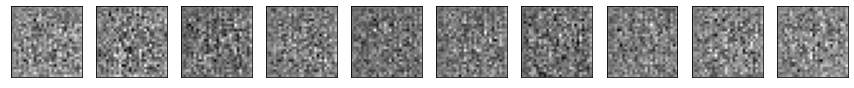

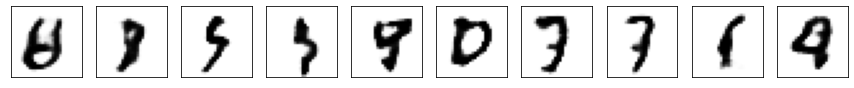

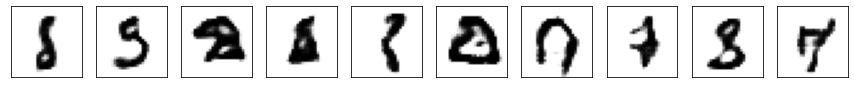

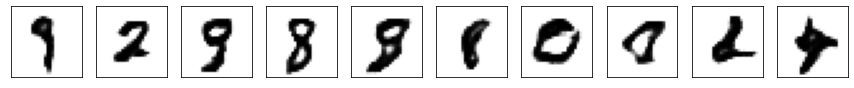

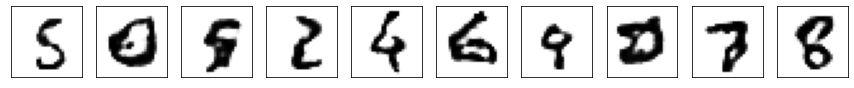

In [82]:
# 모델 만들기
G = build_generator(noise_dims, img_shape)
D = build_discriminator(img_shape)
epochs = 5

# 컴파일
loss = "binary_crossentropy"
optimizer = "adam"

D.compile(loss = loss, optimizer=optimizer )
D.trainable = False
input_noise = layers.Input(shape = noise_dims)
fake_img = G(input_noise)
logit = D(fake_img)
GAN = models.Model(input_noise, logit)
GAN.compile(loss = loss, optimizer = optimizer)
GAN.summary()

for epoch in range(epochs):
    if epoch != 0:
        for real_imgs in ds:  # 32개씩
            noises = tf.random.normal(shape=[batch_size, noise_dims])  # p (가우시안 확률분포)
            fake_imgs = G.predict_on_batch(noises)

            # phase 1. 판별자 훈련
            D.trainable = True
            # 진짜 이미지 (real_imgs)가 들어오면 1, 가짜 이미지 (fake_imgs)가 들어오면 0 출력
            D_loss_real = D.train_on_batch(real_imgs, ones)
            D_loss_fake = D.train_on_batch(fake_imgs, zeros)
            D_loss = (0.5 * D_loss_real + 0.5 * D_loss_fake) / float(batch_size)

            # phase 2. 생성자 훈련
            D.trainable = False
            noises = tf.random.normal(shape=[batch_size, noise_dims])
            G_loss = GAN.train_on_batch(noises, ones)
    
    noises = tf.random.normal(shape=[batch_size, noise_dims])
    fake_imgs = G.predict(noises)
    display_sample_img(fake_imgs[:10])

In [92]:
def get_f_mnist(batch_size=32):
    (x_train, _), (_, _) =tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train / 255
    x_train = np.expand_dims(x_train, 3)
    ds = tf.data.Dataset.from_tensor_slices(x_train)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
    return ds
ds = get_f_mnist()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
Generator (Functional)       (None, 28, 28, 1)         840705    
_________________________________________________________________
Discriminator (Functional)   (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


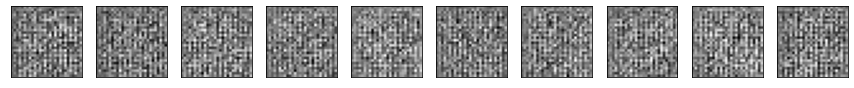

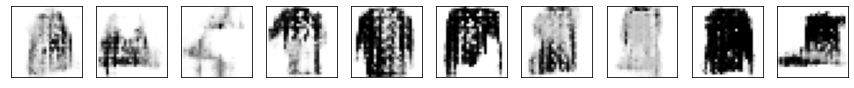

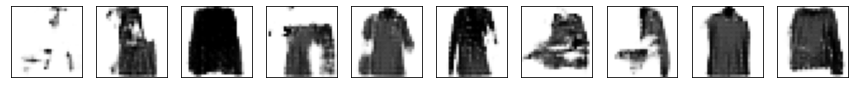

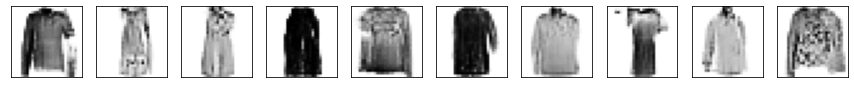

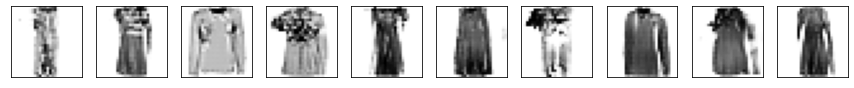

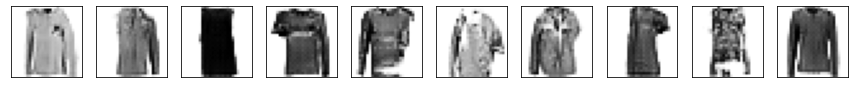

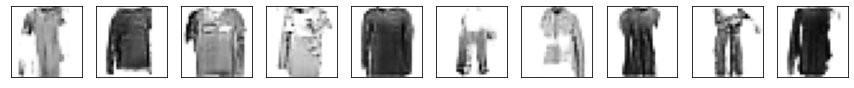

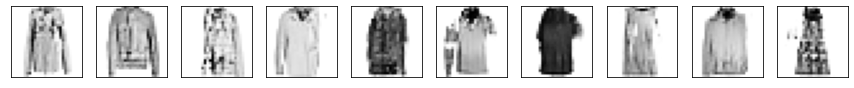

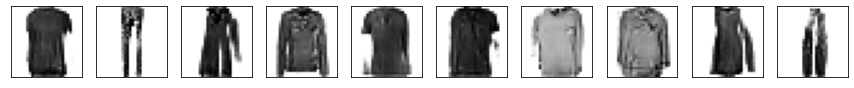

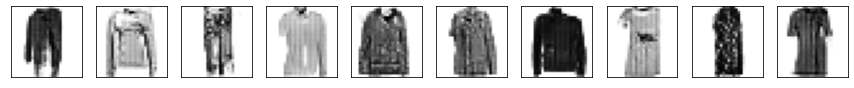

In [93]:
# 모델 만들기
G = build_generator(noise_dims, img_shape)
D = build_discriminator(img_shape)
epochs = 10

# 컴파일
loss = "binary_crossentropy"
optimizer = "adam"

D.compile(loss = loss, optimizer=optimizer )
D.trainable = False
input_noise = layers.Input(shape = noise_dims)
fake_img = G(input_noise)
logit = D(fake_img)
GAN = models.Model(input_noise, logit)
GAN.compile(loss = loss, optimizer = optimizer)
GAN.summary()

for epoch in range(epochs):
    if epoch != 0:
        for real_imgs in ds:  # 32개씩
            noises = tf.random.normal(shape=[batch_size, noise_dims])  # p (가우시안 확률분포)
            fake_imgs = G.predict_on_batch(noises)

            # phase 1. 판별자 훈련
            D.trainable = True
            # 진짜 이미지 (real_imgs)가 들어오면 1, 가짜 이미지 (fake_imgs)가 들어오면 0 출력
            D_loss_real = D.train_on_batch(real_imgs, ones)
            D_loss_fake = D.train_on_batch(fake_imgs, zeros)
            D_loss = (0.5 * D_loss_real + 0.5 * D_loss_fake) / float(batch_size)

            # phase 2. 생성자 훈련
            D.trainable = False
            noises = tf.random.normal(shape=[batch_size, noise_dims])
            G_loss = GAN.train_on_batch(noises, ones)
    
    noises = tf.random.normal(shape=[batch_size, noise_dims])
    fake_imgs = G.predict(noises)
    display_sample_img(fake_imgs[:10])